February: Images for Ocean Sciences poster - speed pcolormesh slices.

In [37]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [38]:
def get_vars_at_depth_OSM(dirname, fname, maskname, dep_ind):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesT) as dsT:
        vozocrtx0 = dsU.variables['vozocrtx'][:,dep_ind,y,x]
        print('U')
        vomecrty0 = dsV.variables['vomecrty'][:,dep_ind,y,x]
        print('V')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        depthu = dsU.variables['depthu'][:]
        nav_lat = dsT.variables['nav_lat'][y, x]
        nav_lon = dsT.variables['nav_lon'][y, x]

    with nc.Dataset(os.path.join(dirname, maskname), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,dep_ind,y,x]
        vmask0 = dsM.variables['vmask'][0,dep_ind,y,x]

    umask = np.tile(umask0, (len(sozotaux), 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux), 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    
    return vozocrtx, vomecrty, umask, vmask, depthu, sozotaux, nav_lat, nav_lon

In [39]:
def get_values(n, vozocrtx, vomecrty, nav_lon, nav_lat, umask):
    U_vel = quicklook.get_1day_avg(vozocrtx, n, n+1)
    V_vel = quicklook.get_1day_avg(vomecrty, n, n+1)
    x_slice, y_slice, u_nstg, v_nstg, speeds = quicklook.get_speeds(U_vel, V_vel, 1)
    xs, ys = nav_lon[:-1, :-1], nav_lat[:-1, :-1]
    umask_fixed = umask[0,:-1,:-1]
    return xs, ys, u_nstg, v_nstg, speeds, umask_fixed

In [48]:
def plot_streamline_day(vozocrtx, vomecrty, nav_lon, nav_lat, umask,
                        vozocrtxp, vomecrtyp, nav_lonp, nav_latp, umaskp,
                        depthu, dep_ind, n, cbarf, cpad, kind):
    vmin, vmax = 0, 0.4
    norm = mpl.colors.Normalize(vmin, vmax)
    levels = np.arange(0, 0.4, 0.05)
    cmap=cmo.cm.matter
    cmap.set_bad('silver')
    
    # child
    xs, ys, u_nstg, v_nstg, speeds, umask_fixed = get_values(n, vozocrtx, vomecrty, nav_lon, nav_lat, umask)
    #parent
    xsp, ysp, u_nstgp, v_nstgp, speedsp, umask_fixedp = get_values(n, vozocrtxp, vomecrtyp, nav_lonp, nav_latp, umaskp)
    
       
    fig, ax = plt.subplots(1, 1, figsize = (20, 15))
    
    y_top = 145
    x_top = 50
    x_half= x_top/2
    x_left = x_top + x_half
    x_right = x_top - x_half
    
    if kind == 'ideal':
        # parent
        pp = ax.pcolormesh(xsp[:y_top, x_top:-x_top], ysp[:y_top, x_top:-x_top], speedsp[:y_top, x_top:-x_top],
                           cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, zorder=1)
        # parent
        csp = ax.contour(xsp[:y_top, x_top:-x_top], ysp[:y_top, x_top:-x_top], speedsp[:y_top, x_top:-x_top],
                         levels = levels, colors='k', alpha=1, zorder=3)
        
    elif kind == 'real':
        # parent
        pp = ax.pcolormesh(xsp[:y_top, x_left:-x_right], ysp[:y_top, x_left:-x_right], speedsp[:y_top, x_left:-x_right],
                           cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, zorder=1)
        # parent
        csp = ax.contour(xsp[:y_top, x_left:-x_right], ysp[:y_top, x_left:-x_right], speedsp[:y_top, x_left:-x_right],
                         levels = levels, colors='k', alpha=1, zorder=3)
    
    # child
    p = ax.pcolormesh(xs, ys, speeds, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, zorder=2)
    
    axins = inset_axes(ax,
                    width="40%",  # width = 10% of parent_bbox width
                    height="5%",  # height : 50%
                    loc=2)
    axins.xaxis.set_ticks_position("bottom")
    #cbar = fig.colorbar(p, cax=axins, orientation="horizontal", ticks=[100, 400, 800, 1200])
    cbar = fig.colorbar(p, cax=axins, orientation='horizontal')#, pad=cpad, fraction=cbarf)
    cbar.set_label('speed [ms$^{-1}$]', fontsize=35, rotation=0, labelpad=3.0)
    tick_locator = ticker.MaxNLocator(nbins=4)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=20)
    ax.tick_params(axis='both', which='both', labelsize=20)
    ax.set_ylabel('Latitude', fontsize=35)
    ax.set_xlabel('Longitude', fontsize=35)
    ax.clabel(csp, inline=1, fontsize=22, fmt='%1.2f')
    w=1/math.cos(math.radians(70.0))
    ax.set_aspect(w)
    fig.tight_layout()
    fig.savefig('../../OSM_images/speed_'+kind+str(int(depthu[dep_ind]))+'_'+str(n+1)+'.png')
    
    return fig

# Depth index

In [41]:
dep_ind = 11

# Ideal

In [42]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_half_flt/'
fname = "1_MCKNZ_1h_20170101_20170120_*"
maskname = '1_mesh_mask.nc'

vozocrtx, vomecrty, umask, vmask, depthu, sozotaux, nav_lat, nav_lon = get_vars_at_depth_OSM(dirname, fname, maskname, dep_ind)

files
U
V


In [43]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_half_flt/'
fname = "MCKNZ_1h_20170101_20170120_*"
maskname = 'mesh_mask.nc'

vozocrtxp, vomecrtyp, umaskp, vmaskp, depthup, sozotauxp, nav_latp, nav_lonp = get_vars_at_depth_OSM(dirname, fname, maskname, dep_ind)

files
U
V


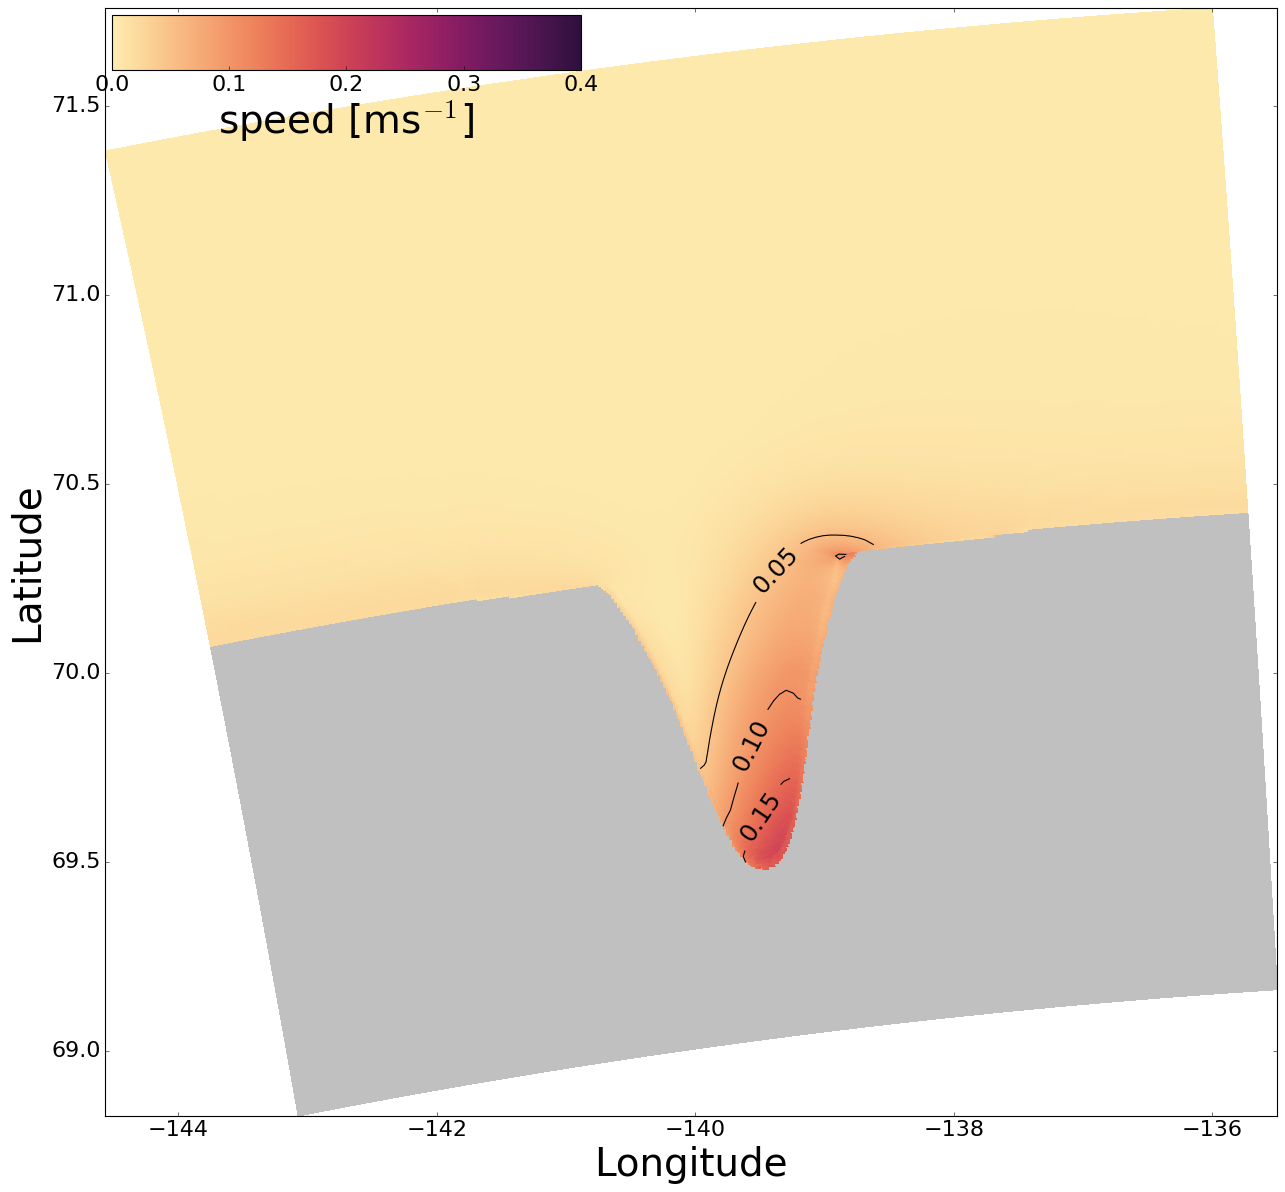

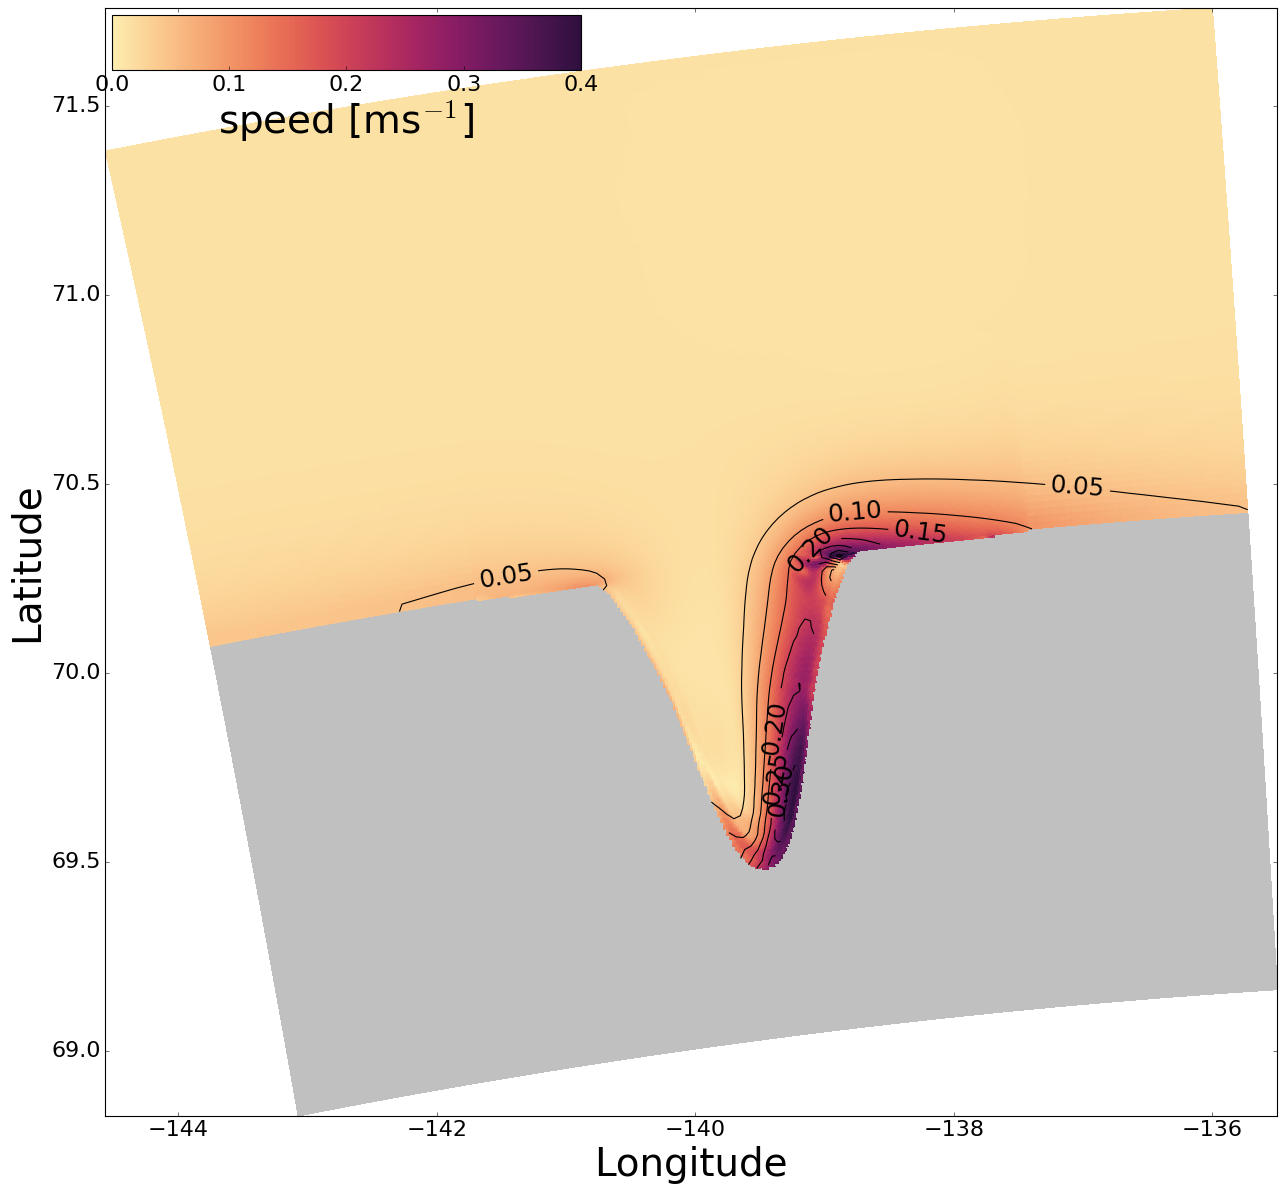

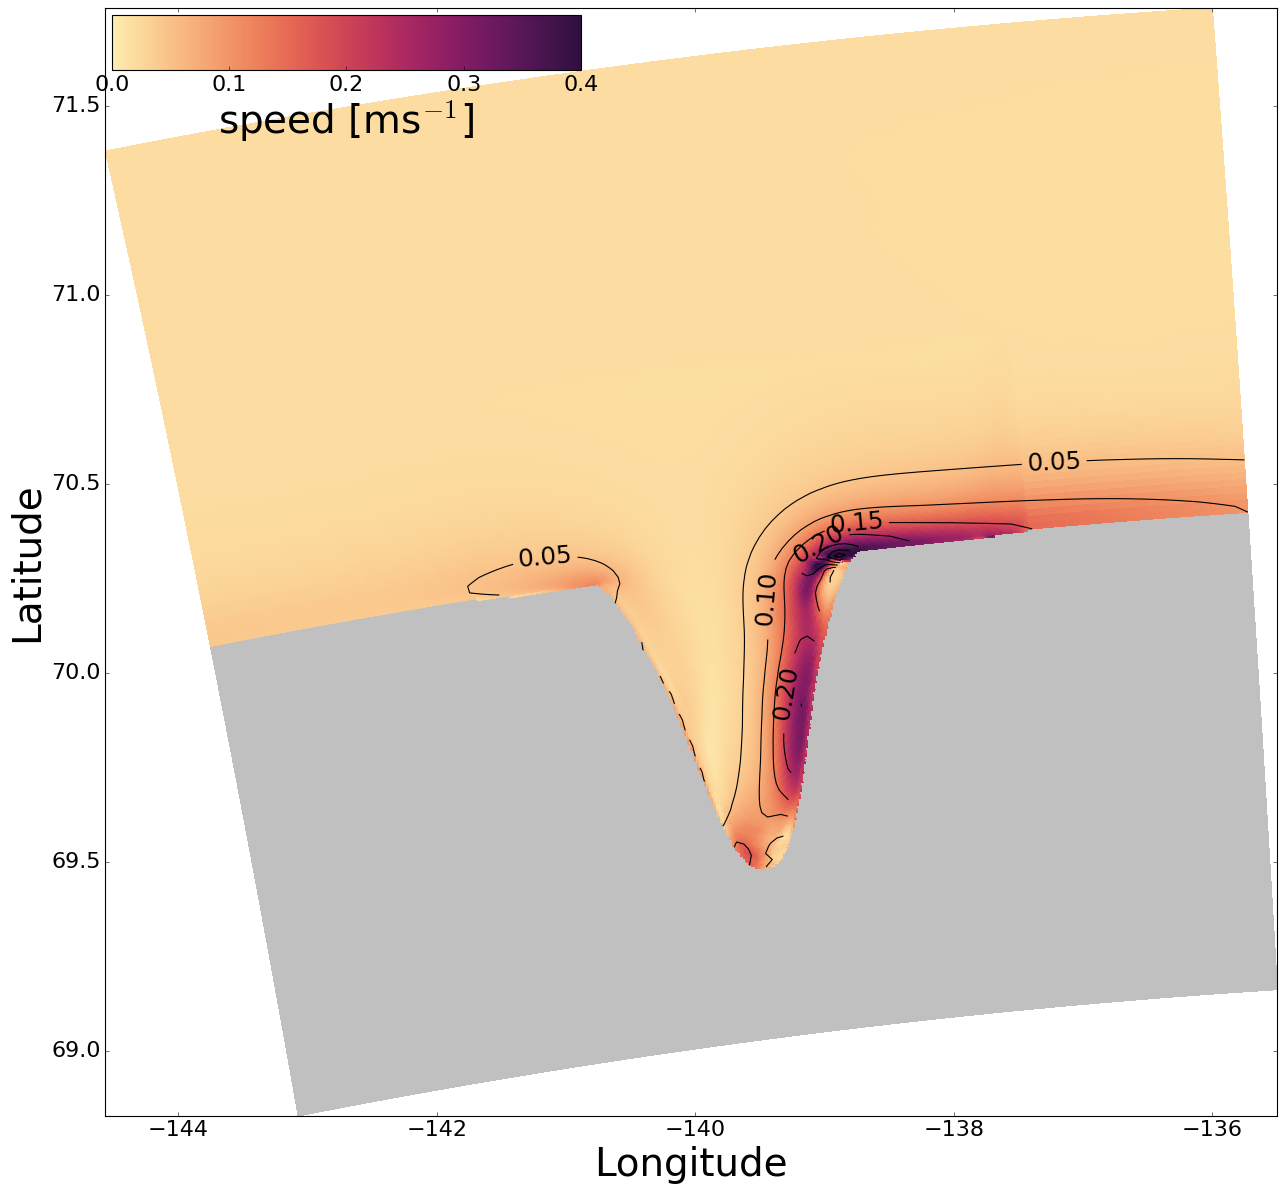

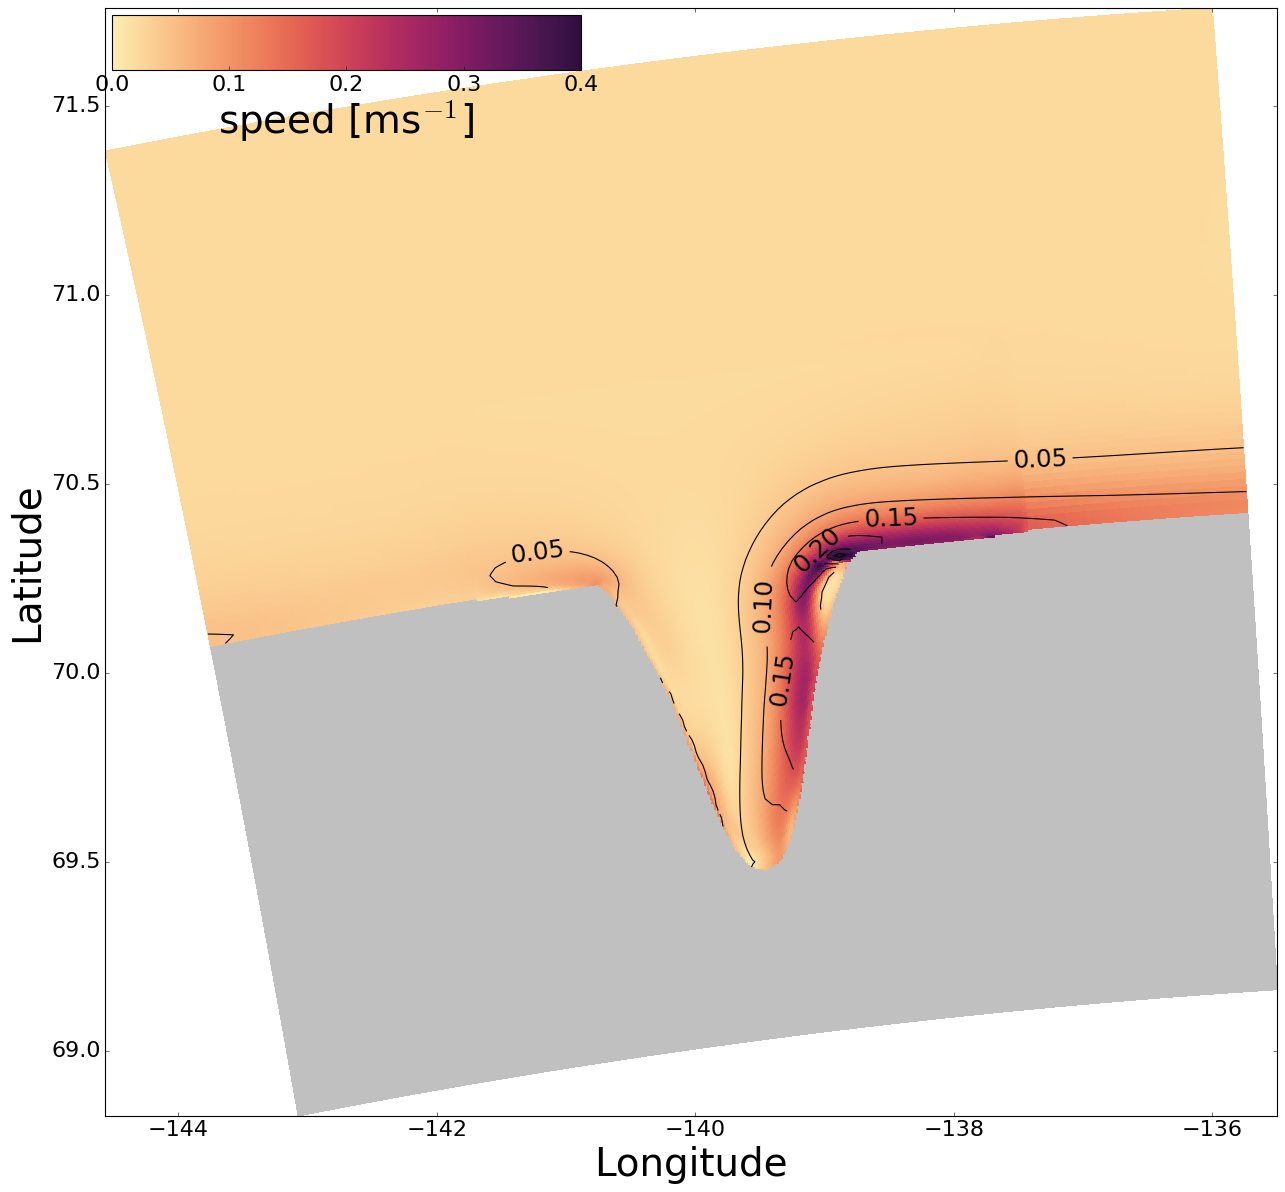

In [49]:
cbarf, cpad = 0.047, 0.07
for n in np.arange(4):
    fig = plot_streamline_day(vozocrtx, vomecrty, nav_lon, nav_lat, umask, vozocrtxp, vomecrtyp, nav_lonp, nav_latp, umaskp, depthu, dep_ind, n, cbarf, cpad, 'ideal')

# Real

In [45]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_half/'
fname = "1_MCKNZ_1h_20170101_20170120_*"
maskname = '1_mesh_mask.nc'

vozocrtxr, vomecrtyr, umaskr, vmaskr, depthur, sozotauxr, nav_latr, nav_lonr = get_vars_at_depth_OSM(dirname, fname, maskname, dep_ind)

files
U
V


In [46]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_half/'
fname = "MCKNZ_1h_20170101_20170120_*"
maskname = 'mesh_mask.nc'

vozocrtxrp, vomecrtyrp, umaskrp, vmaskrp, depthurp, sozotauxrp, nav_latrp, nav_lonrp = get_vars_at_depth_OSM(dirname, fname, maskname, dep_ind)

files
U
V


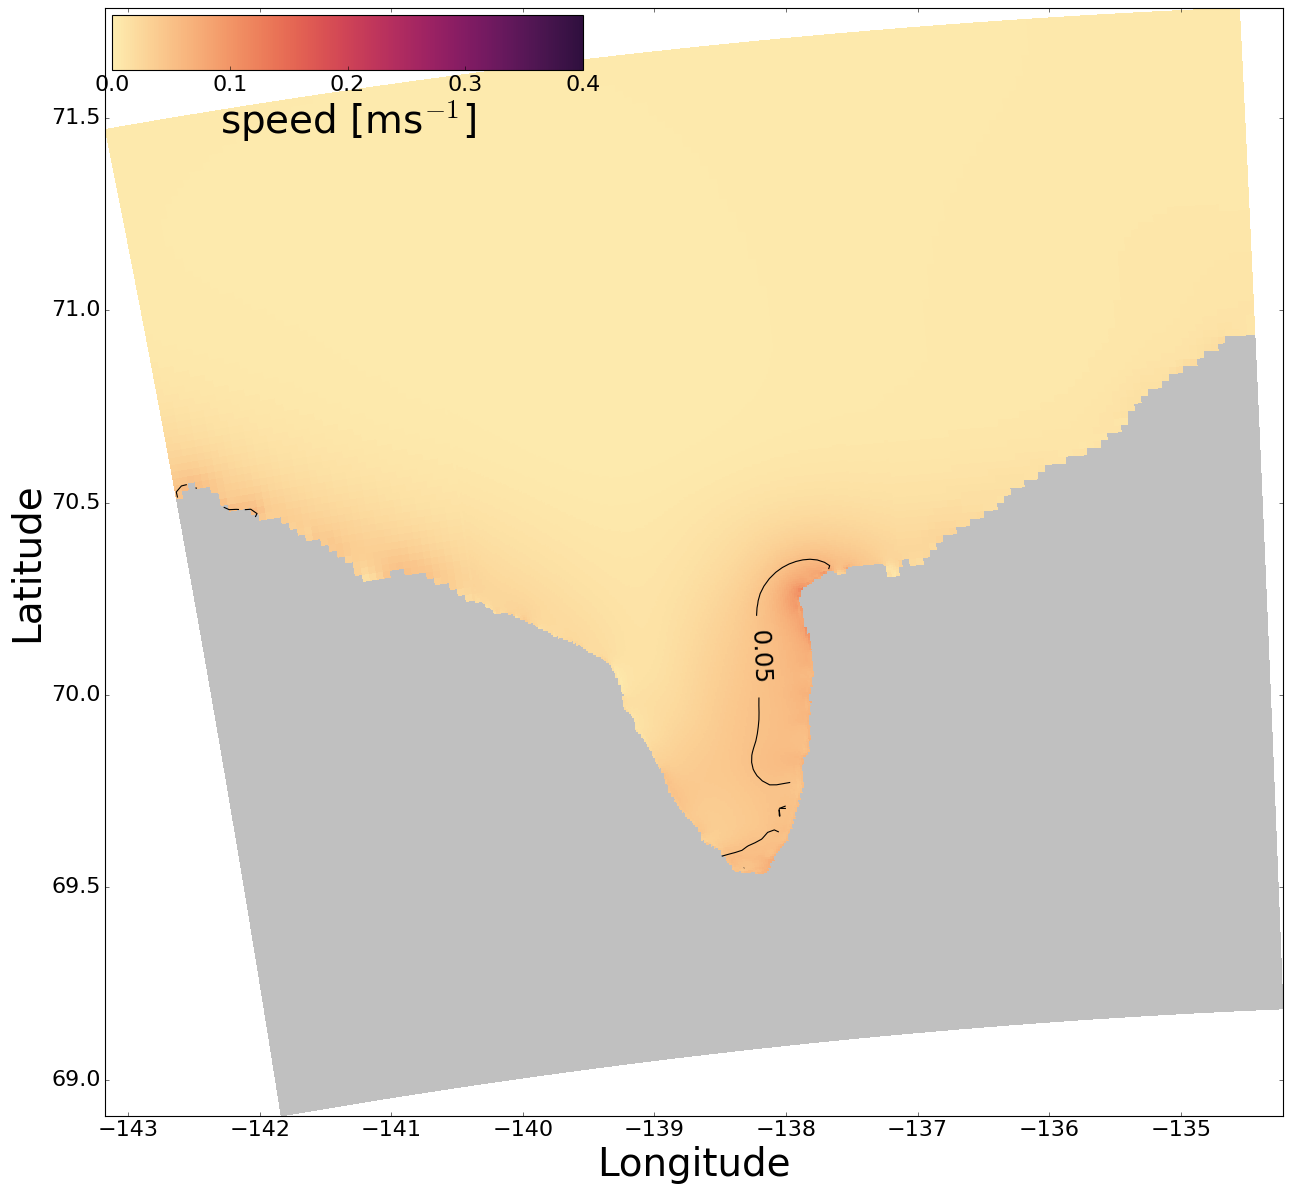

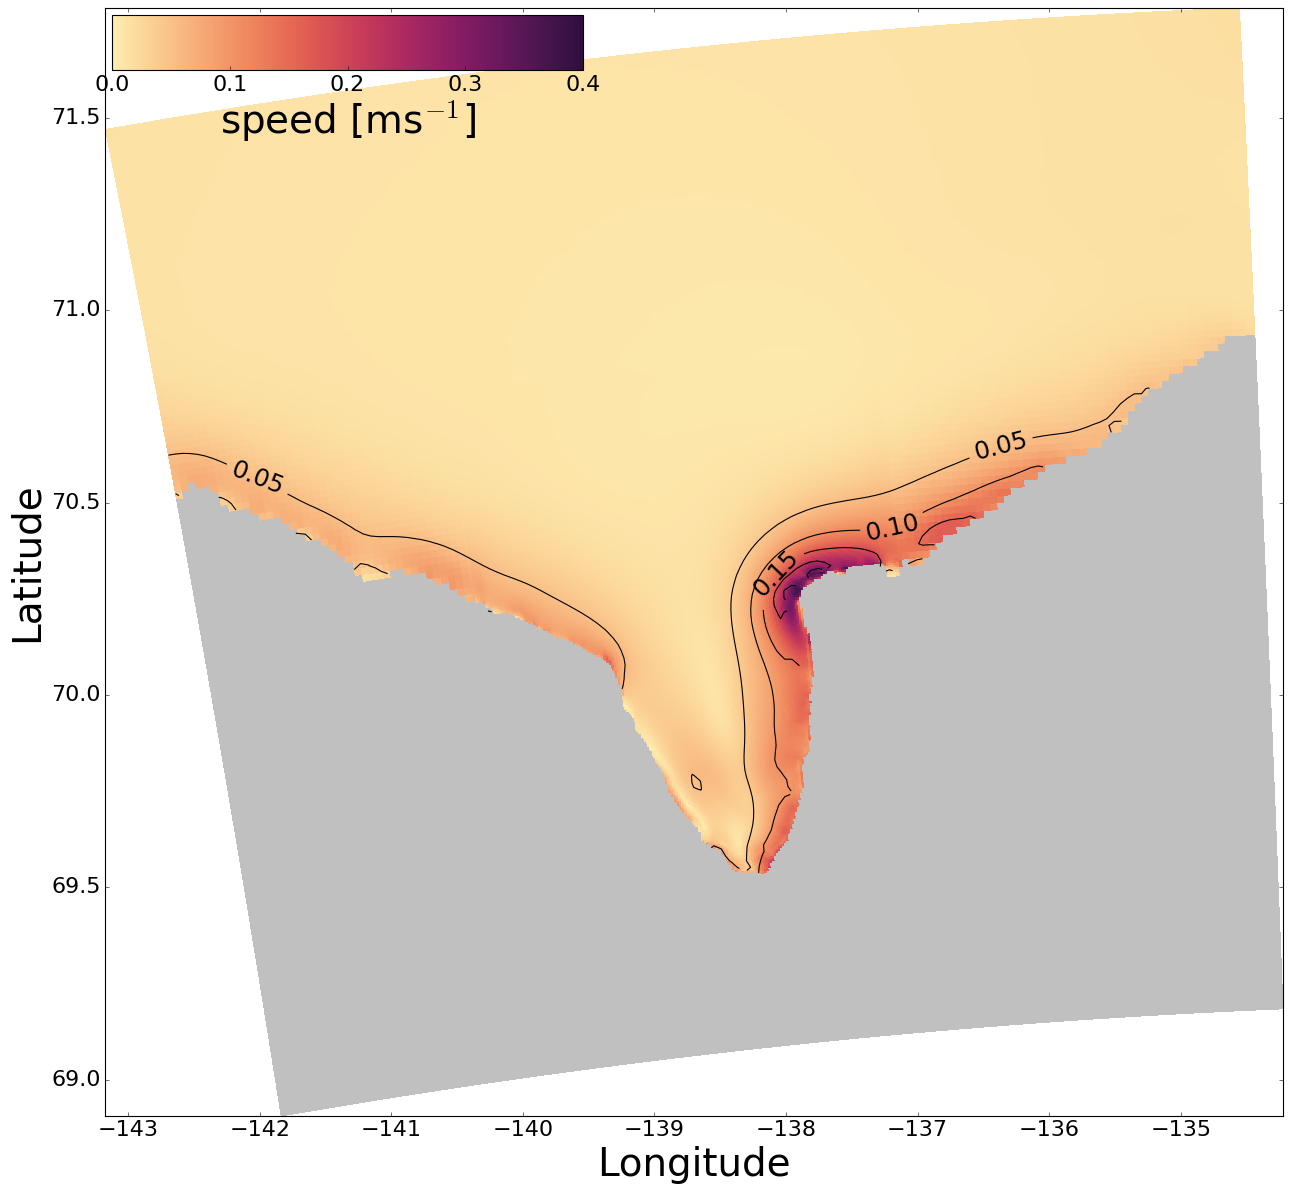

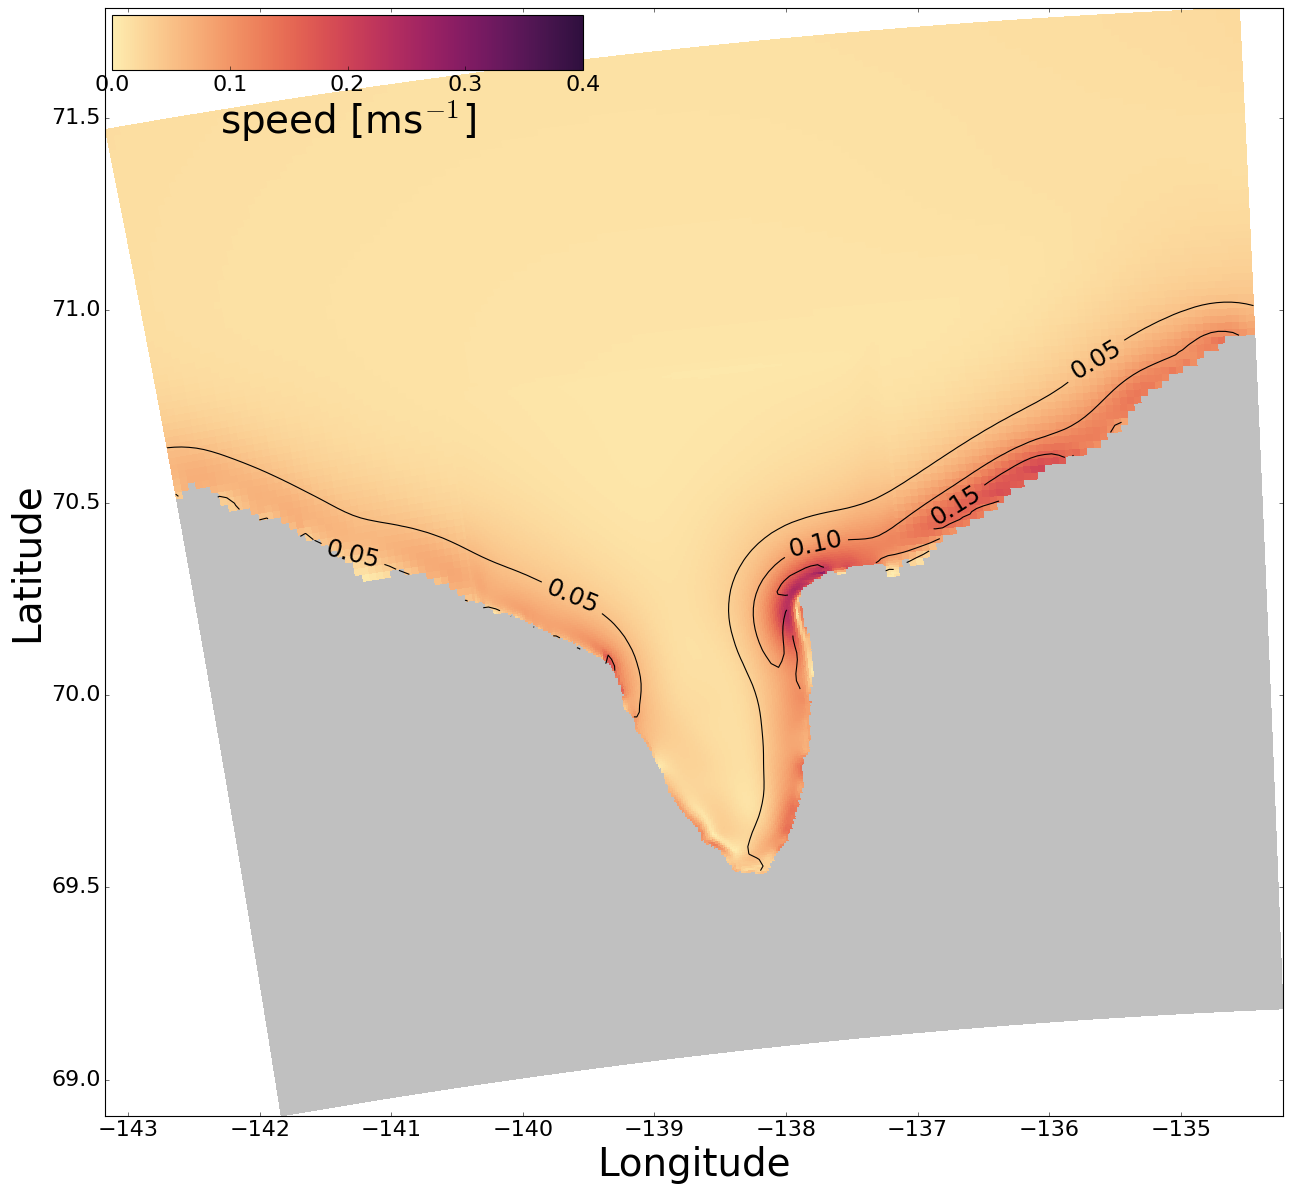

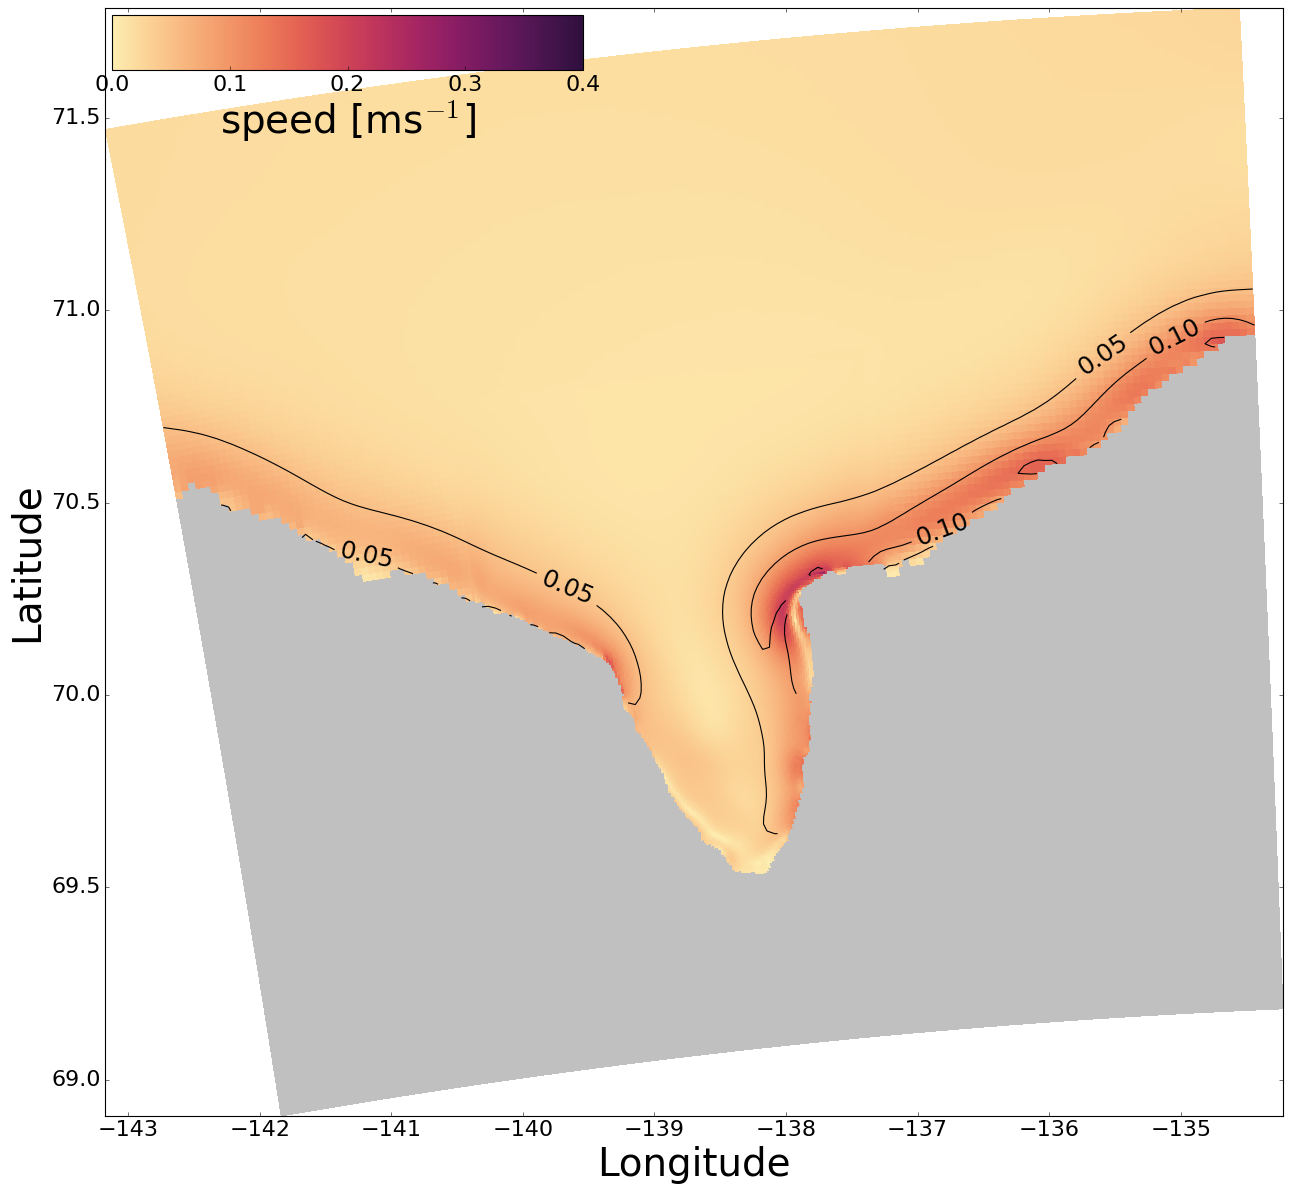

In [50]:
cbarf, cpad = 0.047, 0.07
for n in np.arange(4):
    fig = plot_streamline_day(vozocrtxr, vomecrtyr, nav_lonr, nav_latr, umaskr, vozocrtxrp, vomecrtyrp, nav_lonrp, nav_latrp, umaskrp, depthu, dep_ind, n, cbarf, cpad, 'real')